## Adaptive RAG using **LangGraph** and **LangChain**

### Setup

In [ ]:
%%capture --no-stderr
! pip install -U langchain_community tiktoken  langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

In [ ]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key=userdata.get('TAVILY_API_KEY')

In [ ]:
%%capture --no-stderr
! pip install -U langchain-google-genai

In [ ]:
# Initializing the LLM
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash', api_key=gemini_api_key , temprature=0.3)

### Setting Up the Vector Store and Retriever

In [ ]:
%pip install -qU langchain-huggingface

In [ ]:
# Creating Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls ]
docs_list = [items for sublists in docs for items in sublists]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
split_docs = text_splitter.split_documents(docs_list)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(split_docs, embeddings)
retriever = vectorstore.as_retriever()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Creating LLM Chains and SubChains

In [ ]:
# Router (Routes to Vectore Store or Web Search)
from typing import Literal
from pydantic import BaseModel , Field
from langchain_core.prompts import ChatPromptTemplate

class Route(BaseModel):
  datasource : Literal['DataStore','WebSearch']  = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm_router = llm.with_structured_output(Route)
router_chain = route_prompt | llm_router
result = router_chain.invoke({"question": "What are the types of agent memory?"})
result.datasource # 'DataStore'



'DataStore'

In [ ]:
# Documents Grader
class Grade_Documents(BaseModel):
  binary_score:Literal['yes' , 'no']=Field(description='Is the document relevant to the question?')
llm_grader= llm.with_structured_output(Grade_Documents)
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
grader_chain = grader_prompt | llm_grader
question = 'What is Agent Memory'
documents = retriever.invoke(question)
doc_text = documents[1].page_content
print(grader_chain.invoke({'document':doc_text , 'question':question}))


binary_score='yes'


In [ ]:
# Generate
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")





# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory refers to the ability of an autonomous agent to retain and recall information over time. This is essential for agents to learn from their experiences, make informed decisions, and adapt to changing environments.  There are different types of memory, including short-term memory (in-context learning), and long-term memory (external vector stores). 



In [ ]:
# Hallucination Grader
class Grade_Hallucinatins(BaseModel):

   """Binary score for hallucination present in generation answer."""

   binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

llm_graderh= llm.with_structured_output(Grade_Hallucinatins)
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of Facts: \n\n {document} \n\n LLM generation: {generation}"),
    ]
)
graderh_chain = hallucination_prompt | llm_graderh
print(graderh_chain.invoke({'document':docs , 'generation':generation}))

binary_score='yes'


In [ ]:
# Answer Grader
class Grade_Answer(BaseModel):

   """Binary score for hallucination present in generation answer."""

   binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm_graderANS= llm.with_structured_output(Grade_Answer)
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", " User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
graderANS_chain = answer_prompt | llm_graderANS
print(graderANS_chain.invoke({'question':question , 'generation':generation}))

binary_score='yes'


In [ ]:
### Question Re-writer
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'How does agent memory work and what are its key components? \n'

### Web Search Tool

In [ ]:
import os
os.environ["TAVILY_API_KEY"] = tavily_api_key

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3 )

### Defining Graph State

In [ ]:
from typing_extensions import TypedDict
from typing import List
class state(TypedDict):
  question : str
  generation : str
  documents : List[str]

### NODES

In [ ]:
from langchain.schema import Document


def retrieve(state:state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state:state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state:state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = grader_chain.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state:state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state:state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### EDGES

In [ ]:
from pprint import pprint
def route_question(state:state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = router_chain.invoke({"question": question})
    print(source.datasource)
    if source.datasource == "WebSearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "DataStore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state:state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state:state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = graderh_chain.invoke(
        {"document": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = graderANS_chain.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Creating GRAPH and COMPILATION

In [ ]:
# from langgraph.graph import END, StateGraph, START
# from IPython.display import display
# workflow = StateGraph(state)

# # Define the nodes
# workflow.add_node("web_search", web_search)  # web search
# workflow.add_node("retrieve", retrieve)  # retrieve
# workflow.add_node("grade_documents", grade_documents)  # grade documents
# workflow.add_node("generate", generate)  # generatae
# workflow.add_node("transform_query", transform_query)  # transform_query

# #Defining the worflow
# workflow.add_conditional_edges(
#     START,
#     route_question,
#     {
#         "web_search": "web_search",
#         "vectorstore": "retrieve",
#     },
# )
# workflow.add_edge("web_search", "generate")
# workflow.add_edge("retrieve", "grade_documents")
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "transform_query": "transform_query",
#         "generate": "generate",
#     },
# )
# workflow.add_edge("transform_query", "generate")
# workflow.add_edge("transform_query", "retrieve")
# workflow.add_conditional_edges(
#     "generate",
#     grade_generation_v_documents_and_question,
#     {
#         "not supported": "generate",
#         "useful": END,
#         "not useful": "transform_query",
#     },
# )
# app = workflow.compile()
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(state)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

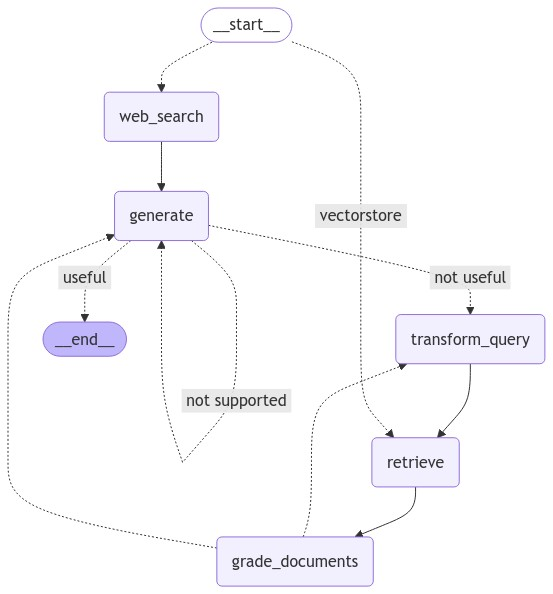

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=0).draw_mermaid_png()))

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What are adversial attacks on llm"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
DataStore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Adversarial attacks on LLMs are inputs designed to make the model produce '
 'undesirable outputs. These attacks can target various tasks like '
 'classification or text generation. Recent research investigates how to make '
 'LLMs more robust against these attacks. \n')
